In [2]:
import os
import numpy as np
import pandas as pd
import sktime
from sktime.datasets import load_from_tsfile
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics.pairwise import pairwise_kernels
from tslearn.metrics import dtw
from fastdtw import fastdtw
from sklearn.utils import resample
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings  # Warning removal
warnings.filterwarnings('ignore')

# DATA_PATH = os.path.join(os.path.dirname(sktime.__file__), r"C:\Users\LJQ\Desktop\DM Assignment new\DuckDuckGeese")

X_train, y_train = load_from_tsfile(
    "FordA_TRAIN.ts", return_data_type="numpy3d"
)
X_test, y_test = load_from_tsfile(
    "FordA_TEST.ts", return_data_type="numpy3d"
)
X_train = X_train.reshape(-1,500)
X_test = X_test.reshape(-1,500)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print(X_train)

[[-0.79717168 -0.66439208 -0.37301463 ... -0.66439208 -1.0737958
  -1.5643427 ]
 [ 0.80485472  0.63462859  0.37347448 ... -0.71488505 -0.56044294
  -0.31908642]
 [ 0.7279851   0.11128392 -0.49912439 ...  0.39446303  0.33940042
   0.25539062]
 ...
 [-0.57005428 -0.33316523 -0.29351853 ... -1.3937145  -0.94273327
  -0.27072168]
 [ 2.0067321   2.0791499   2.0220362  ... -0.43214504 -0.44123126
  -0.28070891]
 [-0.12524091 -0.32536268 -0.48823697 ...  0.55576053  0.57445102
   0.57311598]]


In [3]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

# 将标签为0的训练数据分开
X_train_label_0 = X_train[y_train == 0]
y_train_label_0 = y_train[y_train == 0]

# 将标签为1的训练数据分开
X_train_label_1 = X_train[y_train == 1]
y_train_label_1 = y_train[y_train == 1]

print(X_train_label_0.shape)
print(y_train_label_0.shape)
print(X_train_label_1.shape)
print(y_train_label_1.shape)

train_num = 500
random_rows_label_0 = np.random.choice(X_train_label_0.shape[0], train_num, replace=False)
random_rows_label_1 = np.random.choice(X_train_label_1.shape[0], train_num, replace=False)
X_train_label_0 = X_train_label_0[random_rows_label_0]
X_train_label_1 = X_train_label_1[random_rows_label_1]
y_train_label_0 = y_train_label_0[random_rows_label_0]
y_train_label_1 = y_train_label_1[random_rows_label_1]

X_train = np.vstack((X_train_label_0, X_train_label_1))
y_train = np.hstack((y_train_label_0, y_train_label_1))

# 将标签为0的训练数据分开
X_test_label_0 = X_test[y_test == 0]
y_test_label_0 = y_test[y_test == 0]

# 将标签为1的训练数据分开
X_test_label_1 = X_test[y_test == 1]
y_test_label_1 = y_test[y_test == 1]


test_num = 100
random_rows_label_0 = np.random.choice(X_test_label_0.shape[0], test_num, replace=False)
random_rows_label_1 = np.random.choice(X_test_label_1.shape[0], test_num, replace=False)
X_test_label_0 = X_test_label_0[random_rows_label_0]
X_test_label_1 = X_test_label_1[random_rows_label_1]
y_test_label_0 = y_test_label_0[random_rows_label_0]
y_test_label_1 = y_test_label_1[random_rows_label_1]

X_test = np.vstack((X_test_label_0, X_test_label_1))
y_test = np.hstack((y_test_label_0, y_test_label_1))

(1846, 500)
(1846,)
(1755, 500)
(1755,)


In [4]:
print(X_train.shape)
print(y_train)
print(X_test.shape)
print(y_test)

(1000, 500)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 

In [5]:
def dtw_distance(x, y):
    distance, path = fastdtw(x, y)
    return distance

start = time.time()
dist_mat_train = cdist(X_train, X_train, metric=dtw_distance)
dist_mat_test = cdist(X_test, X_train, metric=dtw_distance)
end = time.time()
print("Cal time:", end-start)


Cal time: 846.8903679847717


In [6]:
# Compute the cauchy kernel with DTW distance for the training and testing sets
sigma = 18
K_train = np.exp(-dist_mat_train / sigma)
K_test = np.exp(-dist_mat_test / sigma)

In [7]:
# Train SVM with combined kernel matrix
model = SVC(kernel='precomputed')

print(y_train)
model.fit(K_train, y_train)

# Predict on new data
y_pred = model.predict(K_test)

print("Accuracy:", np.mean(y_pred == y_test))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

<AxesSubplot:>

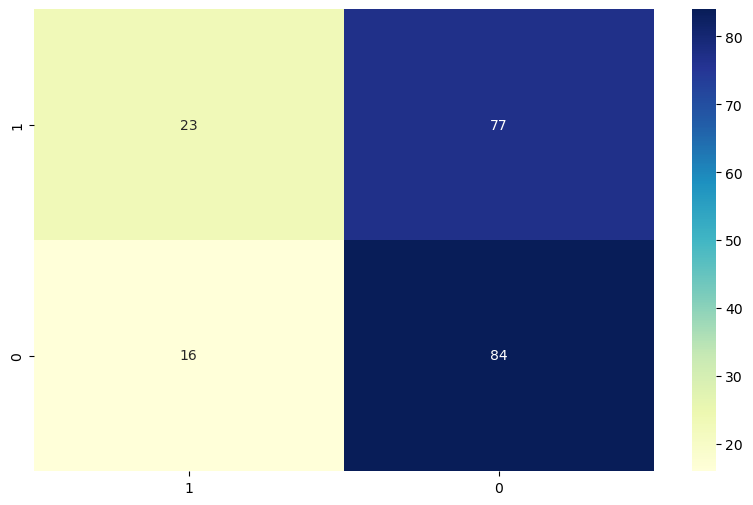

In [8]:
Y_prediction = model.predict(K_test)
#image
cm= confusion_matrix(y_test,Y_prediction)
index = ['1','0'] 
columns = ['1','0']   
cm_df = pd.DataFrame(cm,columns,index) 
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True,fmt="d",cmap="YlGnBu")